Starting data augmentation...
Class counts before augmentation:
         class  count
0       Benign    358
3        Pro-B    557
2        Pre-B    668
1  early Pre-B    685

Starting augmentation to balance classes...
Copying original images...
Progress: 1/4 classes
Progress: 3/4 classes
Progress: 3/4 classes
Augmenting classes...
Augmenting classes...

Verifying class balance after augmentation...

Verifying class balance after augmentation...


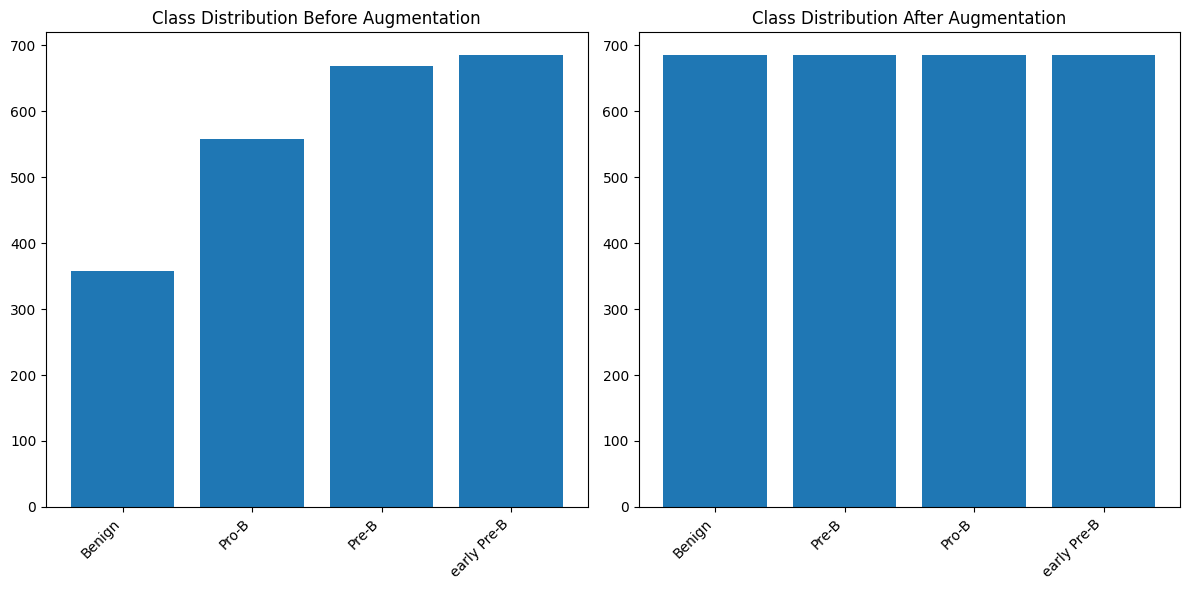

Augmentation complete! Balanced dataset saved to: ..\data\augmented


In [5]:
# Reda: Data Augmentation (blur, noise, flip for class balancing)

import os
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import pandas as pd
# Using regular tqdm instead of tqdm.notebook
from tqdm import tqdm

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Paths
train_path = Path("../data/splits/train")
augmented_path = Path("../data/augmented")
augmented_path.mkdir(parents=True, exist_ok=True)

print("Starting data augmentation...")

# Step 1: Count training images per class
class_counts = {}
for class_dir in train_path.iterdir():
    if class_dir.is_dir():
        # Count files in each class directory
        count = len([f for f in class_dir.iterdir() if f.is_file()])
        class_counts[class_dir.name] = count
        
counts_df = pd.DataFrame(list(class_counts.items()), columns=['class', 'count'])
counts_df = counts_df.sort_values('count')  # Sort by count to identify imbalance

print("Class counts before augmentation:")
print(counts_df)

# Find the largest class count (target for balancing)
max_count = counts_df['count'].max()

# Step 2: Define augmentation functions
def add_gaussian_noise(img, mean=0, sigma=25):
    """Add Gaussian noise to image"""
    img_array = np.array(img)
    noise = np.random.normal(mean, sigma, img_array.shape)
    noisy_img = img_array + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def apply_blur(img, kernel_size=5):
    """Apply Gaussian blur to image"""
    img_array = np.array(img)
    blurred = cv2.GaussianBlur(img_array, (kernel_size, kernel_size), 0)
    return Image.fromarray(blurred)

def flip_horizontal(img):
    """Flip image horizontally"""
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def flip_vertical(img):
    """Flip image vertically"""
    return img.transpose(Image.FLIP_TOP_BOTTOM)

# Step 3: Augment and save images
print("\nStarting augmentation to balance classes...")

# First copy all original images
print("Copying original images...")
class_dirs = list(train_path.iterdir())
for i, class_dir in enumerate(class_dirs):
    if i % 2 == 0:  # Print progress every 2 classes
        print(f"Progress: {i+1}/{len(class_dirs)} classes")
    if class_dir.is_dir():
        class_name = class_dir.name
        # Create corresponding directory in augmented folder
        target_dir = augmented_path / class_name
        target_dir.mkdir(exist_ok=True)
        
        # Copy all original images
        for img_path in class_dir.iterdir():
            if img_path.is_file():
                img = Image.open(img_path).convert('RGB')
                img.save(target_dir / f"orig_{img_path.name}")

# Then augment underrepresented classes
print("Augmenting classes...")
for class_dir in train_path.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        current_count = class_counts[class_name]
        
        # Skip if this class already has max count
        if current_count >= max_count:
            continue
            
        target_dir = augmented_path / class_name
        img_paths = list(class_dir.glob('*'))
        
        # Calculate how many more images we need
        needed = max_count - current_count
        
        # Create needed images through augmentation
        augmentation_count = 0
        while augmentation_count < needed:
            # Pick a random image
            img_path = random.choice(img_paths)
            img = Image.open(img_path).convert('RGB')
            
            # Choose random augmentations
            augmentation_type = random.choice(['noise', 'blur', 'h_flip', 'v_flip'])
            
            if augmentation_type == 'noise':
                aug_img = add_gaussian_noise(img, sigma=random.randint(10, 30))
                aug_name = f"noise_{augmentation_count}_{img_path.name}"
            elif augmentation_type == 'blur':
                aug_img = apply_blur(img, kernel_size=random.choice([3, 5, 7]))
                aug_name = f"blur_{augmentation_count}_{img_path.name}"
            elif augmentation_type == 'h_flip':
                aug_img = flip_horizontal(img)
                aug_name = f"hflip_{augmentation_count}_{img_path.name}"
            else:  # v_flip
                aug_img = flip_vertical(img)
                aug_name = f"vflip_{augmentation_count}_{img_path.name}"
                
            # Save augmented image
            aug_img.save(target_dir / aug_name)
            augmentation_count += 1

# Step 4: Show class distribution after augmentation
print("\nVerifying class balance after augmentation...")
augmented_counts = {}
for class_dir in augmented_path.iterdir():
    if class_dir.is_dir():
        count = len([f for f in class_dir.iterdir() if f.is_file()])
        augmented_counts[class_dir.name] = count

aug_df = pd.DataFrame(list(augmented_counts.items()), columns=['class', 'count'])
aug_df = aug_df.sort_values('class')

# Plot before and after
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(counts_df['class'], counts_df['count'])
plt.title('Class Distribution Before Augmentation')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(aug_df['class'], aug_df['count'])
plt.title('Class Distribution After Augmentation')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Augmentation complete! Balanced dataset saved to:", augmented_path)

# PyTorch Data Augmentation (Alternative Approach)

The approach above works by creating physical augmented files on disk. However, in PyTorch projects, it's more common and efficient to use `torchvision.transforms` to perform augmentation on-the-fly during training. Let's see how that would look:

# Recommendation for the Project

For your Deep Learning project, I recommend using the PyTorch approach above (transforms) during model training rather than creating augmented files. This is the standard approach in PyTorch and offers many advantages:

1. **Memory efficiency**: Augmentation happens in memory during training, not stored on disk
2. **Variety**: Each epoch sees slightly different augmentations of the same image
3. **Easy to tune**: Can quickly adjust augmentation parameters without regenerating files
4. **Industry standard**: This is how most PyTorch-based projects handle augmentation

You can implement this in your `model_training.ipynb` notebook by:
1. Creating the transforms pipelines for train/val/test
2. Using these transforms in your Dataset class
3. Loading the data with DataLoader 

The first approach (generating augmented images) can still be useful if:
- You want to visually inspect the augmentations before training
- You're sharing the augmented dataset with teammates
- You have limited computation during training and want to pre-compute augmentations

Most projects use the PyTorch transforms approach for better efficiency and flexibility.

# PyTorch transforms vs Keras ImageDataGenerator

**Similarities:**
- Both used for image data augmentation in deep learning
- Both support common operations: rotation, flipping, shifting, brightness/contrast adjustment
- Both can be used in training pipelines to generate augmentations on-the-fly

**Differences:**
- **Framework**: `torchvision.transforms` for PyTorch, `ImageDataGenerator` for Keras/TensorFlow
- **Application**: 
  - PyTorch: Compose individual transforms into a pipeline, more modular
  - Keras: Configure a single generator object with all parameters
- **Workflow**:
  - PyTorch: Define transforms → Apply in Dataset → Use in DataLoader
  - Keras: Create generator → Configure with params → Use flow methods

**Example in Keras (equivalent to our PyTorch code):**
```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    rescale=1./255,  # Scaling instead of normalization
    validation_split=0.2
)

# Use the generator
train_generator = train_datagen.flow_from_directory(
    '../data/splits/train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)
```

Both approaches achieve similar results but with syntax that matches their respective framework's design philosophy.

# Simple PyTorch Transforms (No OOP)

Let's create a much simpler version without classes, just showing the basics of torchvision transforms:

Selected random image: ..\data\splits\train\early Pre-B\Sap_148 (92).jpg (Class: early Pre-B)
Tensor shape: torch.Size([3, 224, 224])


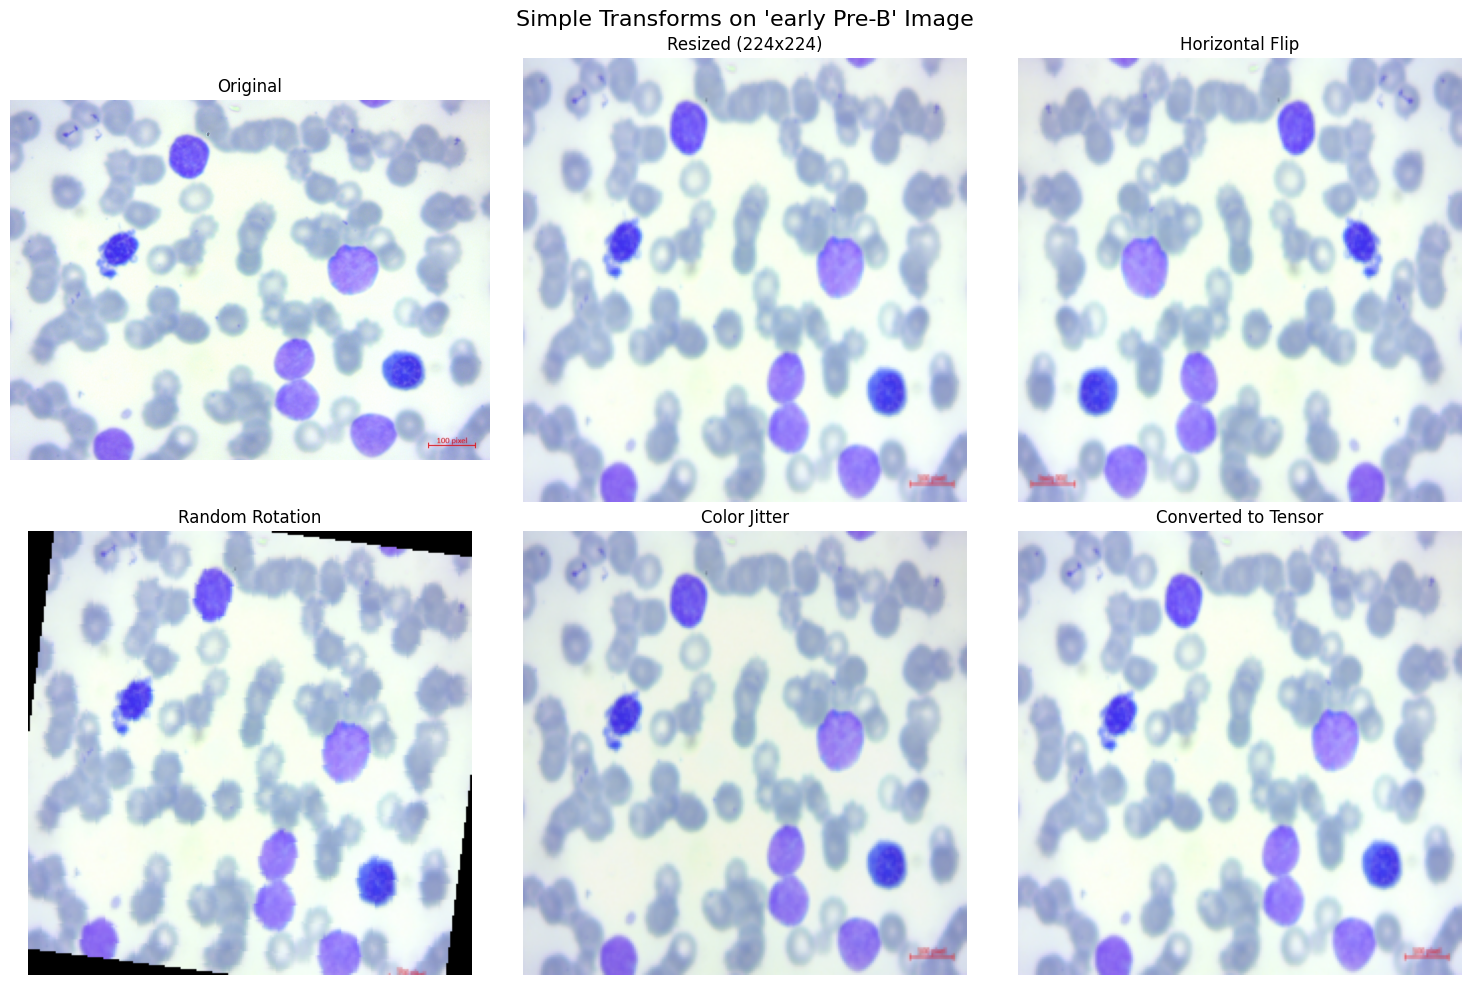


Applying composed transforms (multiple transforms at once):


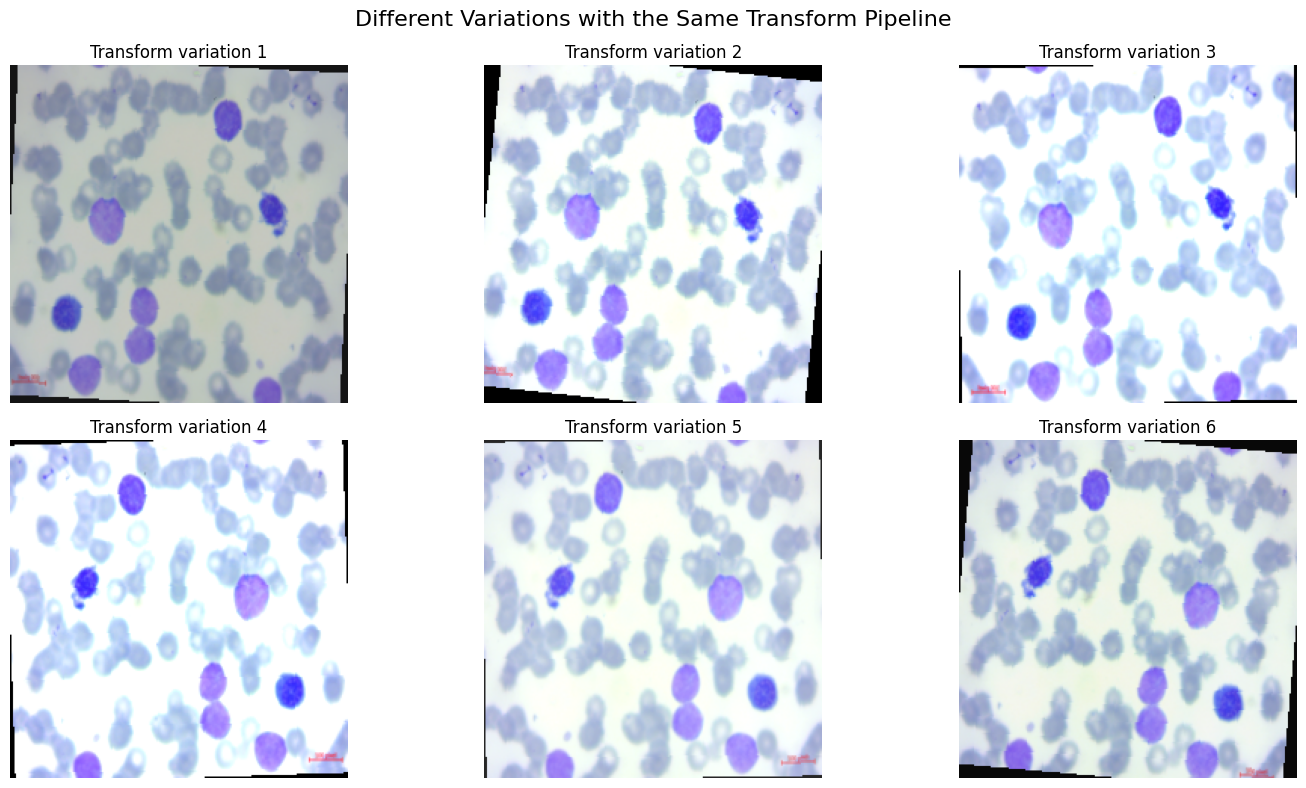

This is the power of transforms - each time you apply the same pipeline,
you get a different random variation of the same image.


In [7]:
# Simple version - direct transforms on images (no classes)

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np

# 1. Setup basic paths
train_path = Path("../data/splits/train")
if not train_path.exists():
    print(f"Train data not found at {train_path}. Complete data preparation first.")
else:
    # 2. Find a random image to demonstrate transforms
    image_paths = []
    for class_dir in train_path.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.glob('*'):
                if img_path.is_file():
                    image_paths.append((str(img_path), class_dir.name))
    
    if not image_paths:
        print("No images found.")
    else:
        # Pick a random image
        random.seed(42)
        img_path, class_name = random.choice(image_paths)
        print(f"Selected random image: {img_path} (Class: {class_name})")
        
        # 3. Load the image
        original_img = Image.open(img_path).convert('RGB')
        
        # 4. Define individual transforms
        resize = transforms.Resize((224, 224))
        h_flip = transforms.RandomHorizontalFlip(p=1.0)  # p=1.0 means always apply
        rotation = transforms.RandomRotation(degrees=30)
        color_jitter = transforms.ColorJitter(brightness=0.5)
        to_tensor = transforms.ToTensor()
        
        # 5. Apply transforms one by one
        resized_img = resize(original_img)
        flipped_img = h_flip(resized_img)
        rotated_img = rotation(resized_img)
        color_img = color_jitter(resized_img)
        
        # Convert to tensor (needed for training)
        tensor_img = to_tensor(resized_img)
        print(f"Tensor shape: {tensor_img.shape}")  # Should be [3, 224, 224]
        
        # 6. Show the transforms
        plt.figure(figsize=(15, 10))
        
        plt.subplot(231)
        plt.imshow(original_img)
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(232)
        plt.imshow(resized_img)
        plt.title("Resized (224x224)")
        plt.axis('off')
        
        plt.subplot(233)
        plt.imshow(flipped_img)
        plt.title("Horizontal Flip")
        plt.axis('off')
        
        plt.subplot(234)
        plt.imshow(rotated_img)
        plt.title("Random Rotation")
        plt.axis('off')
        
        plt.subplot(235)
        plt.imshow(color_img)
        plt.title("Color Jitter")
        plt.axis('off')
        
        plt.subplot(236)
        # Convert tensor back to image for display
        np_img = tensor_img.permute(1, 2, 0).numpy()
        plt.imshow(np_img)
        plt.title("Converted to Tensor")
        plt.axis('off')
        
        plt.suptitle(f"Simple Transforms on '{class_name}' Image", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # 7. Compose multiple transforms (the typical way in PyTorch)
        print("\nApplying composed transforms (multiple transforms at once):")
        
        # Create a transform pipeline
        transform_pipeline = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor()
        ])
        
        # Create multiple versions of the same image
        plt.figure(figsize=(15, 8))
        
        for i in range(6):
            # Apply all transforms in the pipeline
            transformed_img = transform_pipeline(original_img)
            
            # Convert tensor back to image for display
            np_img = transformed_img.permute(1, 2, 0).numpy()
            
            plt.subplot(2, 3, i+1)
            plt.imshow(np_img)
            plt.title(f"Transform variation {i+1}")
            plt.axis('off')
        
        plt.suptitle("Different Variations with the Same Transform Pipeline", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        print("This is the power of transforms - each time you apply the same pipeline,")
        print("you get a different random variation of the same image.")

# Simple Guide to Using Transforms in Your Project

To use transforms in your project, you just need to:

1. **Define your transforms pipeline**:
```python
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
```

2. **Apply it to images during loading**:
```python
# When loading a single image
img = Image.open("some_image.jpg")
transformed_img = train_transforms(img)  # Now it's a tensor

# For your training loop
for img_path in image_paths:
    img = Image.open(img_path)
    tensor = train_transforms(img)
    # Use tensor for training
```

That's all you need! The transforms will be applied to each image, with random variations for augmentations.

When it's time to build your full training pipeline, the transforms get integrated into your data loading, but the core concept is very simple.